In [1]:
import numpy as np, matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

In [2]:
# Read in the mc
neutrinos = np.genfromtxt("./neutrino_mc.csv", delimiter=',', names=True)
muons = np.genfromtxt("./muon_mc.csv", delimiter=',', names=True)

In [3]:
# Read in the hyperplane parameters
hp_nue_cc = np.genfromtxt("./hyperplanes_nue_cc.csv", delimiter=',', names=True)
hp_numu_cc = np.genfromtxt("./hyperplanes_numu_cc.csv", delimiter=',', names=True)
hp_nutau_cc = np.genfromtxt("./hyperplanes_nutau_cc.csv", delimiter=',', names=True)
hp_nu_nc = np.genfromtxt("./hyperplanes_all_nc.csv", delimiter=',', names=True)
hp_muons = np.genfromtxt("hyperplanes_muon.csv", delimiter=',', names=True)

In [4]:
# The bestfit values for Analysis A NC+CC from Table 2
best_fit = {'ice_absorption': 101.5,
            'ice_scattering': 103.0,
            'opt_eff_headon': -0.63,
            'opt_eff_lateral': 0.49,
            'opt_eff_overall': 98.4,
            'coin_fraction': 0.01}

In [5]:
# Write the function definition for neutrinos
# This will take the values for each parameter and return
# the modified weight for each event
def apply_neutrinos(neutrinos=neutrinos,
                    hyperplanes = {0: hp_nu_nc,
                                   12: hp_nue_cc,
                                   14: hp_numu_cc,
                                   16: hp_nutau_cc,},
                    ice_absorption = 100.0,
                    ice_scattering = 100.0,
                    opt_eff_headon = 0.0,
                    opt_eff_lateral = 0.0,
                    opt_eff_overall = 100.0,
                    coin_fraction = 0.0,
                    **kwargs):
    
    # Copy the weights so we can modify them and 
    # assign an "interaction type" corresponding to
    # nue CC, numu CC, nutau CC or NC
    output_weights = np.copy(neutrinos['weight'])
    int_type = np.copy(neutrinos['pdg']).astype(int)
    int_type[neutrinos['type']==0] = 0 
    int_type = np.abs(int_type)

    # Apply each neutrino flavor separately using the PDG
    # codes for each. Note that we're using 0 for NC interactions
    # and 12/14/16 for nue/numu/nutau CC interactions respectively
    for flavor, hp in hyperplanes.items():
        bins_cz = hyperplanes[flavor]['reco_coszen']
        bins_en = hyperplanes[flavor]['reco_energy']
        bins_pid = hyperplanes[flavor]['pid']
        bins = np.array([bins_cz, bins_en, bins_pid]).T
        
        modifications = hp['offset'] + \
                        hp['ice_scattering'] * (ice_scattering-100)/100. +\
                        hp['ice_absorption'] * (ice_absorption-100)/100. +\
                        hp['opt_eff_lateral'] * (10*opt_eff_lateral) +\
                        hp['opt_eff_headon'] * (opt_eff_headon) +\
                        hp['opt_eff_overall'] * (opt_eff_overall-100)/100. +\
                        hp['coin_fraction'] * (coin_fraction)
        
        # Apply the modifications for a single neutrino flavor
        for i, b in enumerate(bins):
            mask = (int_type==flavor)
            mask &= (neutrinos['reco_coszen'] == b[0])
            mask &= (neutrinos['reco_energy'] == b[1])
            mask &= (neutrinos['pid'] == b[2])
            output_weights[mask] *= modifications[i]
        
    return output_weights
        

In [6]:
# Write the function definition for muons
# This will take the values for each parameter and return
# the modified weight for each event
def apply_muons(muons=muons,
                hyperplane = hp_muons,
                ice_absorption = 100.0,
                ice_scattering = 100.0,
                opt_eff_headon = 0.0,
                opt_eff_lateral = 0.0,
                opt_eff_overall = 100.0,
                **kwargs):
    
    # Copy the weights so we can modify them
    output_weights = np.copy(muons['weight'])

    # Get the bins for the muons
    bins_cz = hyperplane['reco_coszen']
    bins_en = hyperplane['reco_energy']
    bins_pid = hyperplane['pid']
    bins = np.array([bins_cz, bins_en, bins_pid]).T
        
    modifications = hyperplane['offset'] +\
        hyperplane['ice_scattering']*(ice_scattering-100)/100. +\
        hyperplane['opt_eff_lateral']*(10*opt_eff_lateral) +\
        hyperplane['opt_eff_headon']*(opt_eff_headon) +\
        hyperplane['ice_absorption']*(np.exp(hyperplane['ice_absorption_expslope']*(ice_absorption/100.-1.0))-1) +\
        hyperplane['opt_eff_overall']*(np.exp(hyperplane['opt_eff_overall_expslope']*(opt_eff_overall/100.-1.0))-1)

    # Apply the modifications to the muon weights
    for i, b in enumerate(bins):
        mask = (muons['reco_coszen'] == b[0])
        mask &= (muons['reco_energy'] == b[1])
        mask &= (muons['pid'] == b[2])
        output_weights[mask] *= modifications[i]
        
    return output_weights
        

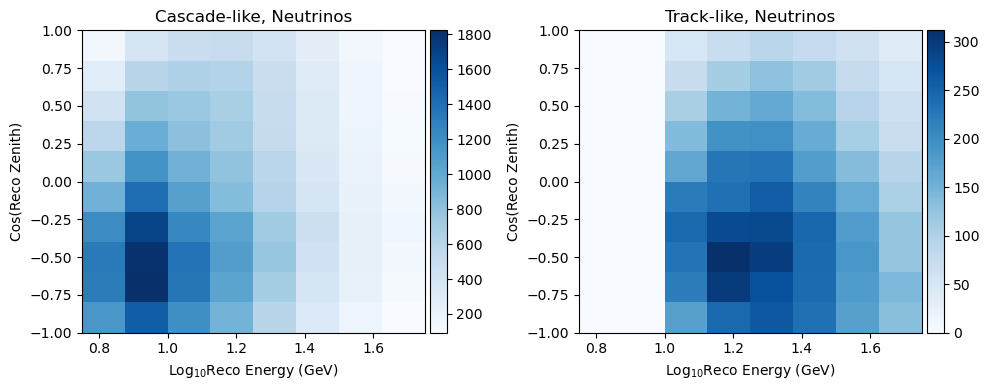

In [7]:
# Make a plot of the neutrinos just to verify the shape is correct
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])
bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#neutrino_weights = neutrino_muons()
neutrino_weights = apply_neutrinos(**best_fit)

# A flux model must be assumed for the neutrinos
# Here, use a simple flux of phi=800*E^-3.7 
# Note that this is only for the purposes of an
# example: fits performed using this sample should
# use a numerical flux calculation such as the one
# presented in PhysRevD.92.023004
# In principle, this is also where you would apply
# the neutrino oscillation probabilities
# TODO add oscillation probabilities?
neutrino_weights *= 800*neutrinos['true_energy']**-3.7

# Scale to the livetime of the data
neutrino_weights *= 1006*24*3600. 

# Make the histogram, binning in energy, zenith, and pid
nu_hist, edges = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                 neutrinos['reco_coszen'],
                                 neutrinos['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights)
nu_hist = np.swapaxes(nu_hist, 0, 1)

# Calculate the weighted error of each bin on the histogram
# TODO this might be an incorrect way of calculating the statistical error 
# caused by the limited MC statistics
# Source: https://stackoverflow.com/questions/48227037/error-on-weighted-histogram-in-python
nu_err = np.sqrt(
    np.histogramdd([np.log10(neutrinos['reco_energy']),
                    neutrinos['reco_coszen'],
                    neutrinos['pid']],
    bins = [bins_en, bins_cz, bins_pid],
    weights = neutrino_weights**2)[0]
)
# Swap axis 0 and 1 to match the data format and for easier plotting
nu_err = np.swapaxes(nu_err, 0, 1)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,0],
                       cmap='Blues')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,1],
                       cmap='Blues')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Neutrinos')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Neutrinos')

fig.tight_layout()

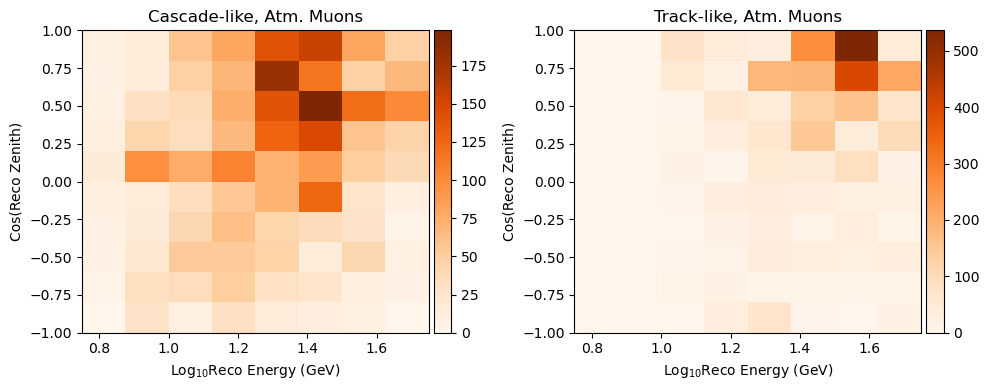

In [38]:
# Make a plot of the muons just to verify the shape is correct
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])
bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#muon_weights = np.copy(muons['weight'])
#muon_weights = apply_muons()
muon_weights = apply_muons(**best_fit)

# Weights are in Hz. Convert to about the 
# livetime given in Section IV
# Corresponding to the number of seconds that the experiment was live. 
# Roughly 3 years.
muon_weights *= 1006*24*3600. 

# Make the histogram, binning in energy, zenith, and pid
muon_hist, edges = np.histogramdd([np.log10(muons['reco_energy']),
                                   muons['reco_coszen'],
                                   muons['pid']],
                                  bins = [bins_en, bins_cz, bins_pid],
                                  weights = muon_weights)
muon_hist = np.swapaxes(muon_hist, 0, 1)
# Calculate the weighted error of each bin on the histogram
# TODO this might be an incorrect way of calculating the statistical error 
# caused by the limited MC statistics. See same code above for neutrinos
muon_err = np.sqrt(
    np.histogramdd([np.log10(muons['reco_energy']),
                    muons['reco_coszen'],
                    muons['pid']],
        bins = [bins_en, bins_cz, bins_pid],
        weights = muon_weights**2)[0]
)
muon_err = np.swapaxes(muon_err, 0, 1)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       muon_hist[:,:,0],
                       cmap='Oranges')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       muon_hist[:,:,1],
                       cmap='Oranges')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Atm. Muons')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Atm. Muons')

fig.tight_layout()

## Plot actual detected data

In [9]:
data = np.genfromtxt("./data.csv", delimiter=',', names=True)

In [10]:
cascades = data[data["pid"] == 0]
tracks = data[data["pid"] == 1]

# Reshape the count column in the cascade array into a 2D array. 
# The rows should correspond to a sorted reco_coszen and the columns should be the sorted reco_energy
cascades_count = cascades["count"].reshape((len(bins_en)-1, len(bins_cz)-1)).T[::-1, ...]
track_count = tracks["count"].reshape((len(bins_en)-1-2, len(bins_cz)-1)).T[::-1, ...]

In [11]:
cascades["reco_energy"].reshape((len(bins_en)-1, len(bins_cz)-1)).T[::-1, ...]

array([[ 6.6,  8.7, 11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [ 6.6,  8.7, 11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [ 6.6,  8.7, 11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [ 6.6,  8.7, 11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [ 6.6,  8.7, 11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [ 6.6,  8.7, 11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [ 6.6,  8.7, 11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [ 6.6,  8.7, 11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [ 6.6,  8.7, 11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [ 6.6,  8.7, 11.7, 15.6, 20.7, 27.7, 36.9, 49.2]])

In [12]:
cascades["reco_coszen"].reshape((len(bins_en)-1, len(bins_cz)-1)).T[::-1, ...]

array([[ 0.9,  0.9,  0.9,  0.9,  0.9,  0.9,  0.9,  0.9],
       [ 0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
       [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
       [-0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7],
       [-0.9, -0.9, -0.9, -0.9, -0.9, -0.9, -0.9, -0.9]])

In [13]:
tracks["reco_energy"].reshape((len(bins_en)-1-2, len(bins_cz)-1)).T[::-1, ...]

array([[11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [11.7, 15.6, 20.7, 27.7, 36.9, 49.2],
       [11.7, 15.6, 20.7, 27.7, 36.9, 49.2]])

In [14]:
tracks["reco_coszen"].reshape((len(bins_en)-1-2, len(bins_cz)-1)).T[::-1, ...]

array([[ 0.9,  0.9,  0.9,  0.9,  0.9,  0.9],
       [ 0.7,  0.7,  0.7,  0.7,  0.7,  0.7],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.3,  0.3,  0.3,  0.3,  0.3,  0.3],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
       [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
       [-0.3, -0.3, -0.3, -0.3, -0.3, -0.3],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.7, -0.7, -0.7, -0.7, -0.7, -0.7],
       [-0.9, -0.9, -0.9, -0.9, -0.9, -0.9]])

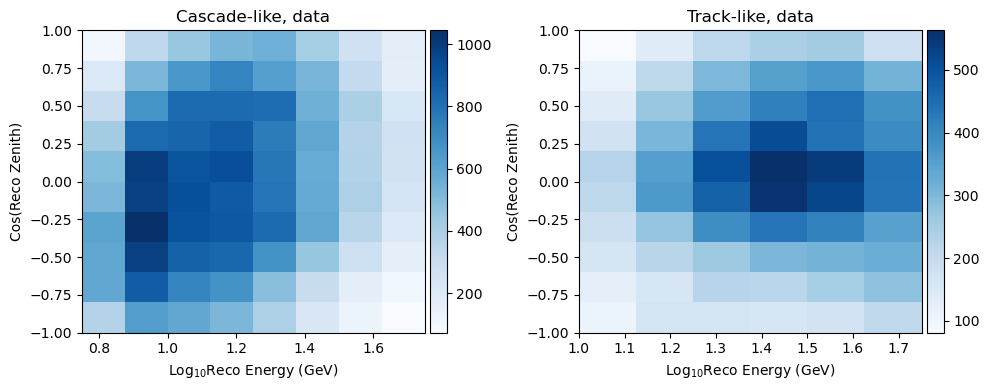

In [15]:
# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       cascades_count,
                       cmap='Blues')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en[2:], 
                       bins_cz,
                       track_count,
                       cmap='Blues')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, data')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, data')

fig.tight_layout()

## Plot comparison of data with MC prediction

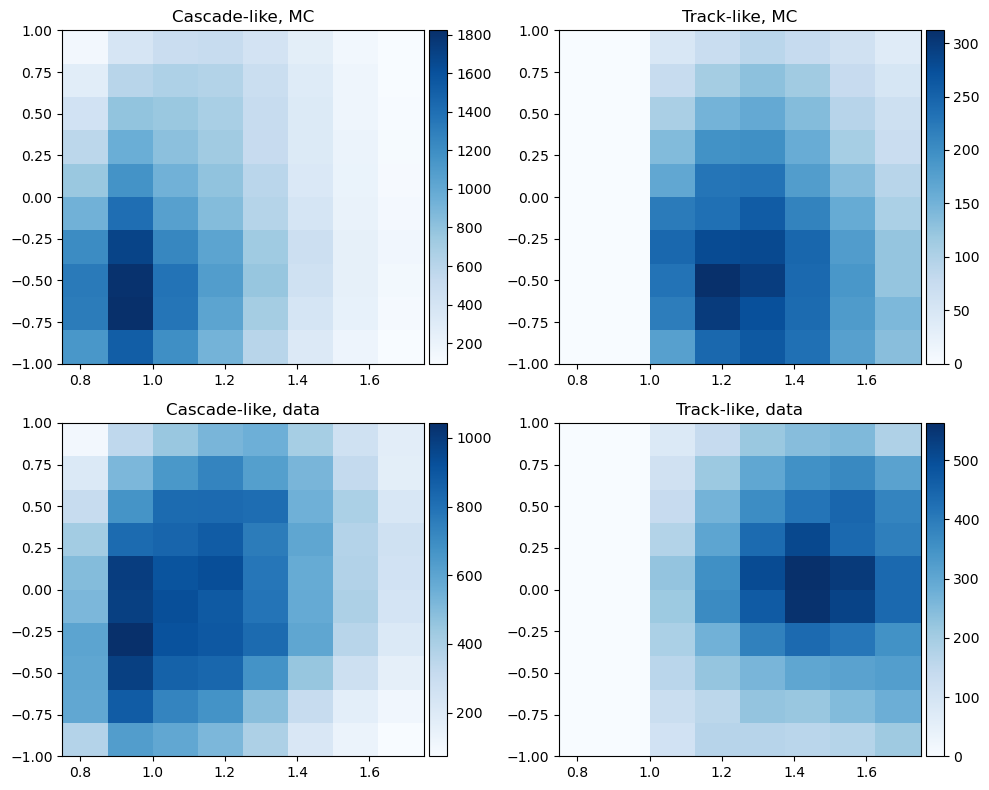

In [37]:
# Make a a 2x2 grid of subplots with 2D histograms. 
# The top row should be the combined MC data (i.e. neutrinos and muons)
# The bottom row should be the data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 8))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,0],# + muon_hist[:,:,0],
                       cmap='Blues')
ax1.set_title('Cascade-like, MC')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en,
                        bins_cz,
                        nu_hist[:,:,1],# + muon_hist[:,:,1],
                        cmap='Blues')
ax2.set_title('Track-like, MC')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax3.pcolormesh(bins_en,
                        bins_cz,
                        cascades_count,
                        cmap='Blues')
ax3.set_title('Cascade-like, data')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

track_padded = np.pad(track_count, ((0,0),(2,0)), 'constant', constant_values=0)
cmesh = ax4.pcolormesh(bins_en,
                        bins_cz,
                        track_padded,
                        cmap='Blues')
ax4.set_title('Track-like, data')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

fig.tight_layout()

The track-like data looks nothing like the track-like MC. Something seems to be wrong here. Is it the flux calculation perhaps? Or is it the fact that I have not taken the oscillations into account?

### Compare data with MC on 1D projections

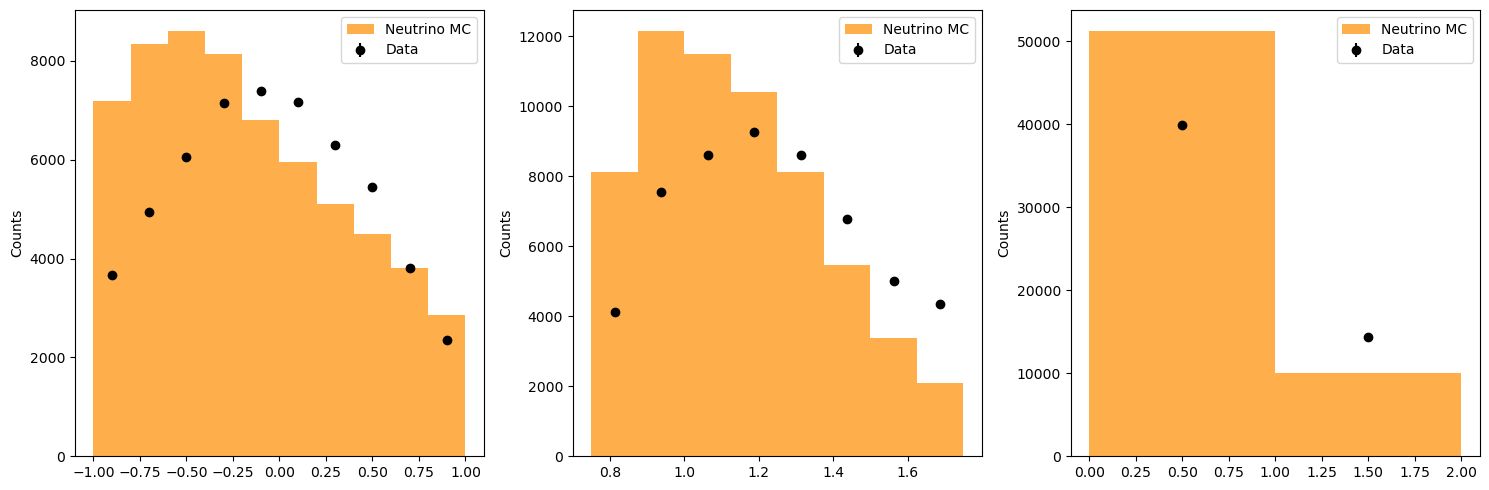

In [22]:
# Make a 3D histogram of the data where the track histogram has been padded with 0s to have the same shape as the cascades
track_padded = np.zeros_like(cascades_count)
track_padded[:, 2:] = track_count
data_hist = np.stack([cascades_count, track_padded], axis=-1) - muon_hist
# Make a projection on each 3D axis of histogram for both the data and MC
# Plot each projection on the same figure but in separate subplots
# Subtract the muon MC from the data histogram
# The MC data is a filled histogram, while the data is a scatter plot
fig, axs = plt.subplots(1,3, figsize=(15, 5))
for i, (ax, bins) in enumerate(zip(axs, [bins_cz, bins_en, bins_pid])):
    axes_to_sum = tuple(set(range(3)) - set([i]))
    nu_mc_proj = nu_hist.sum(axis=axes_to_sum)
    data_proj = data_hist.sum(axis=axes_to_sum)
    ax.stairs(nu_mc_proj, bins, fill=True, alpha=0.7, label="Neutrino MC", color="darkorange")
    ax.errorbar((bins[1:] + bins[:-1])/2, data_proj, yerr=np.sqrt(data_proj), fmt='o', label="Data", c="k")
    ax.set_ylabel("Counts")
    ax.legend(loc="upper right")

fig.tight_layout()

## Calculate $\chi^2$ value
The data above is the sum of all backgrounds (muon background, non-neutrino backgrounds, and tau neutrino interactions). This should then be compared to the sum of all simulated backgrounds and signal to calculate how well the two distributions match. This is done using a $\chi^2$ test. The $\chi^2$ value is defined as:
$$
\chi^2 = \sum_{i\in \{bins\}} \frac{(N_i^{exp} - N_i^{obs})^2}{N_i^{exp} + (\sigma_i^{exp})^2} + \sum_{j\in\{syst\}} \frac{(s_j - \hat s_j)^2}{\sigma_{s_j}^2}
$$

- $N_i^{exp}$: expected number of events in bin $i$
- $N_i^{obs}$: observed number of events in bin $i$
- $\sigma_i^{exp}$: statistical uncertainty in bin $i$ due to the finite statistics of MC simulations. Maybe this can be calculated using the weighted errors of the MC events stored in the csv files? TODO ask Chad and Jason
- $s_j$: central value of nuisance parameter $j$
- $\hat s_j$: maximum likelihood estimate of nuisance parameter $j$
- $\sigma_{s_j}$: uncertainty in nuisance parameter $j$, from the Gaussian standard deviation of the nuisance parameter

The nuisance parameters, their standard deviations, and their best fit values can be found in table II of the paper.

The final $\chi^2$ value that was achieved for the best fit of all nuisance parameters was 127.6, so we expect to get a similar value.

Later, we want to change the value of the tau normalization to check what $\chi^2$ values we get in those situations.

In [26]:
nuisance_parameters = pd.DataFrame({
    "nue_numu_ratio": [1.0, 0.05, 1.03, 1.03],
    "nue_up_hor_flux_ratio": [0.0, 1., -0.42, -0.33],
    "spectral_index": [0., 0.1, 0.03, 0.03],
    "effective_livetime": [np.nan, np.nan, 2.21, 2.24],
    "M_A_quasielastic": [0.99, (0.248+0.149)/2, 1.05, 1.05], # Upper and lower bounds
    "M_A_resonance": [1.12, 0.22, 1., 0.99],
    "NC_norm": [1., 0.2, 1.05, 1.06],
    "theta_13": [8.5, 0.21, np.nan, np.nan],
    "theta_23": [np.nan, np.nan, 49.8, 50.2],
    "delta_m2_32": [np.nan, np.nan, 2.53, 2.56],
    "opt_eff_all": [100, 10, 98.4, 98.4],
    "opt_eff_lat": [0, 1, 0.49, 0.48],
    "opt_eff_headon": [np.nan, np.nan, -0.63, -0.64],
    "bulk_ice_scattering": [100, 10, 103, 102.8],
    "bulk_ice_absorption": [100, 10, 101.5, 101.7],
    "atm_mu_frac": [np.nan, np.nan, 8.1, 8.0],
    "mu_spectral_index": [0., 1., 0.15, 0.15],
    "coin_nu_mu_frac": [0., 0.1, 0.01, 0.01],   # TODO only +, not +-. Maybe the standard deviation is a fraction of 0.1?
    "nu_tau_norm": [np.nan, np.nan, 0.73, 0.57]
}, index=["prior", "prior_error", "best_fit_cc_nc", "best_fit_cc"]).T
nuisance_parameters

,prior,prior_error,best_fit_cc_nc,best_fit_cc
nue_numu_ratio,1.00,0.0500,1.03,1.03
nue_up_hor_flux_ratio,0.00,1.0000,-0.42,-0.33
spectral_index,0.00,0.1000,0.03,0.03
effective_livetime,NaN,NaN,2.21,2.24
M_A_quasielastic,0.99,0.1985,1.05,1.05
M_A_resonance,1.12,0.2200,1.00,0.99
NC_norm,1.00,0.2000,1.05,1.06
theta_13,8.50,0.2100,NaN,NaN
theta_23,NaN,NaN,49.80,50.20
delta_m2_32,NaN,NaN,2.53,2.56


In [29]:
systematics = nuisance_parameters.dropna(axis=0)
sys_chi2 = np.sum((systematics["prior"] - systematics["best_fit_cc_nc"])**2 / systematics["prior_error"]**2)
sys_chi2

1.4884860019687816

In [31]:
# MC total expected event counts
mc_hist = nu_hist + muon_hist
# Error on the number of events due to the limited MC statistics. 
# TODO can we add these errors like this? I think so but worth double-checking
mc_err = np.sqrt(nu_err**2 + muon_err**2)

In [36]:
mc_cascades = mc_hist[:,:,0]
mc_tracks = mc_hist[:,2:,1]
mc_cascade_err = mc_err[:,:,0]
mc_track_err = mc_err[:,2:,1]

chi2 = (
    np.sum((mc_cascades - cascades_count)**2 / (mc_cascades + mc_cascade_err**2))
    + np.sum((mc_tracks - track_count)**2 / (mc_tracks + mc_track_err**2))
    + sys_chi2
)

chi2

10347.68707188562

## Sanity check of data and MC
The data and MC counts should be the same as in table I

In [55]:
data["count"].sum()

62112.0

^ This is the same as in table I

In [59]:
nu_hist.sum() + muon_hist.sum()

69097.54306434444

^ This should be close to 62203. Maybe it is the error in the flux approximation of neutrinos?

In [60]:
muon_hist.sum()

7801.590629444567

^ This should be 5022 but is instead much larger. Why is that the case?

## Systematic uncertainties